In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math as math
import os

exec(open("../header.py").read())

Header initialized


In [303]:
raw_train_data = pd.read_csv(processed_root("03-bag-of-words/threshold-30/bow_train_data.csv"))
raw_val_data = pd.read_csv(processed_root("03-bag-of-words/threshold-30/bow_val_data.csv"))
raw_test_data = pd.read_csv(processed_root("03-bag-of-words/threshold-30/bow_test_data.csv"))

In [304]:
raw_train_data['poetry_text'].values[0]

'—was this\nthat one fairest river lovd\nto blend murmur nurs song\nand alder shade rocki falls\nand ford shallow sent voice\nthat flowd along dream didst thou\no derwent travel green plains\nnear sweet birthplac didst thou beauteous stream\nmak ceaseless music night day\nwhich steadi cadenc tempering\nour human wayward composd thoughts\nto infant soft give me\namong fret dwell mankind\na knowledg dim earnest calm\nthat natur breath among hill groves\nwhen left mountain towers\nof cockermouth beauteous river came\nbehind father hous passd close by\nalong margin terrac walk\nh playmat dear lovd\noh mani time five year child\na nake boy one delight rill\na littl millrac severd stream\nmad one long bath summer day\nbaskd sun plung baskd again\naltern summer day coursd\nov sandi field leap groves\nof yellow grunsel crag hill\nth wood distant skiddaw lofti height\nwer bronzd deep radianc stood alone\nbeneath sky born\non indian plain mother hut\nhad run abroad wanton sport\na nake savag thu

In [305]:
raw_train_data

,poetry_text,wind\nand,quaint,sympathi,meet,life\nand,high,among,steep,splendour,...,advers,casual,i\n\ni,divers,midway,optic,charl,incess,outrag,poetry_author
0,—was this\nthat one fairest river lovd\nto ble...,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,William Wordsworth
1,sun arise\nand make happi skies\nth merri bell...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,William Blake
2,all truth sound bitter\na one first believes\n...,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Robert Browning
3,load brush basket cradl chairs\nlabour along s...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Thomas Hardy
4,sappho\nyea thou shalt forgotten like spilt wi...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Algernon Charles Swinburne
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1118,cri men “i would crucified”\n\nand said “whi b...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Kahlil Gibran
1119,silent silent night\nquench holi light\nof thi...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,William Blake
1120,youth told certain citi everi one lived\naccor...,0,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,Kahlil Gibran
1121,one love more mor sincer lie everywher place ...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Alice Notley


### Feature Engineering

Average word length, average words per line, average syllables per line, rhyme (different rhyme schemes, or number of rhymes etc.), genre (nature, love, etc., use embedding space to find out how close the poems are to each genre) 

In [306]:
import string
import nltk
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.stem.snowball import SnowballStemmer
import enchant
import re

In [307]:
# intializing checkeres
d = enchant.Dict("en_US")
lemmatizer = WordNetLemmatizer()
stemmer = SnowballStemmer("english")

In [308]:
def word_suggestions(w):
    if d.check(w) == False:
        sugggestions = d.suggest(w)
        if len(sugggestions) > 0:
            w = d.suggest(w)[0]
    return w

In [309]:
def str_cleanup(s):
    """given a line of a poem, get rid of punctuation, all lowercase, etc"""
    # all lower case
    s = s.lower()
    # first split into words
    s = s.split(" ") 
    # get rid of punctuation
    s = list(map(lambda x: re.sub("[.,-/\"'();:{}=!?%^&*]","",x), s))
    # getting rid of empty string
    while '' in s:
        s.remove('') 
    # spell checks
    s = list(map(word_suggestions, s))
    return s

In [310]:
first_poem = raw_train_data['poetry_text'].values[0]
first_poem = first_poem.split("\n")

#### Average word length

In [311]:
def ave_word_len(poem):
    lines = poem.split("\n")
    p = list(map(str_cleanup, lines))
    # get rid of none types
    p_none = filter(None.__ne__, p)
    p = list(p_none)
    word_lens = []
    for line in p:
        for word in line:
            word_lens.append(len(word))
    return np.mean(word_lens)

In [312]:
ave_word_lens = list(map(ave_word_len, raw_train_data['poetry_text'].values))

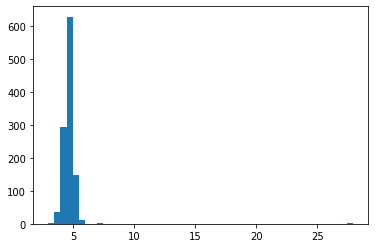

In [313]:
plt.hist(ave_word_lens, bins=50)
plt.show()

#### Average words per line

In [314]:
def ave_line_len(poem):
    lines = poem.split("\n")
    p = list(map(str_cleanup, lines))
    # get rid of none types
    p_none = filter(None.__ne__, p)
    p = list(p_none)
    return np.mean(list(map(len, p)))

In [315]:
ave_line_lens = list(map(ave_line_len, raw_train_data['poetry_text'].values))

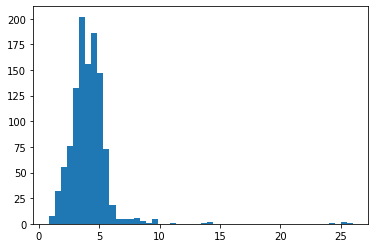

In [316]:
plt.hist(ave_line_lens, bins=50)
plt.show()

#### Average syllables per line

In [317]:
from nltk.tokenize import SyllableTokenizer

In [318]:
SSP = SyllableTokenizer()

In [319]:
def ave_syllables_line(poem):
    lines = poem.split("\n")
    p = list(map(str_cleanup, lines))
    # get rid of none types
    p_none = filter(None.__ne__, p)
    p = list(p_none)
    num_syllables = []
    for line in p:
        syl_list = list(map(lambda x: SSP.tokenize(x), line))
        num_syllables.append(sum([len(x) for x in syl_list]))
    return np.mean(num_syllables)

In [320]:
ave_syllable_lens = list(map(ave_syllables_line, raw_train_data['poetry_text'].values))

/Users/aysjajohnson/.pyenv/versions/3.7.4/lib/python3.7/site-packages/nltk/tokenize/sonority_sequencing.py:104: UserWarning: Character not defined in sonority_hierarchy, assigning as vowel: 'ﬂ'
  " assigning as vowel: '{}'".format(c)
/Users/aysjajohnson/.pyenv/versions/3.7.4/lib/python3.7/site-packages/nltk/tokenize/sonority_sequencing.py:104: UserWarning: Character not defined in sonority_hierarchy, assigning as vowel: 'ﬁ'
  " assigning as vowel: '{}'".format(c)
/Users/aysjajohnson/.pyenv/versions/3.7.4/lib/python3.7/site-packages/nltk/tokenize/sonority_sequencing.py:104: UserWarning: Character not defined in sonority_hierarchy, assigning as vowel: '’'
  " assigning as vowel: '{}'".format(c)
/Users/aysjajohnson/.pyenv/versions/3.7.4/lib/python3.7/site-packages/nltk/tokenize/sonority_sequencing.py:104: UserWarning: Character not defined in sonority_hierarchy, assigning as vowel: 'à'
  " assigning as vowel: '{}'".format(c)
/Users/aysjajohnson/.pyenv/versions/3.7.4/lib/python3.7/site-pac

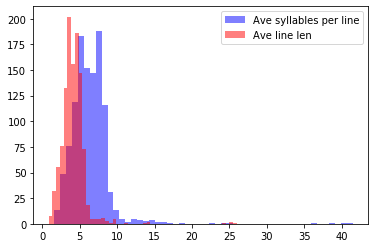

In [321]:
plt.hist(ave_syllable_lens, bins=50, color='b', alpha=0.5, label = 'Ave syllables per line')
plt.hist(ave_line_lens, bins=50, color='r', alpha = 0.5, label = 'Ave line len')
plt.legend()
plt.show()

#### Rhymes

For now, just record if there are any rhymes (i.e., binary)

In [322]:
import pronouncing

In [323]:
def has_rhyme(poem):
    lines = poem.split("\n")
    p = list(map(str_cleanup, lines))
    # get rid of none types
    while [] in p:
        p.remove([])
    rhymes = 0
    last_rhyme = p[0][-1]
    for line in p:
        current_rhyme = line[-1]
        if last_rhyme != current_rhyme:
            if current_rhyme in pronouncing.rhymes(last_rhyme):
                rhymes = 1
        last_rhyme = current_rhyme
    return rhymes

In [324]:
rhymes = list(map(has_rhyme, raw_train_data['poetry_text'].values))

In [325]:
print("Number of non-rhyming poems: ", len(rhymes) - sum(rhymes), "Number of rhyming poems: ", sum(rhymes))

Number of non-rhyming poems:  688 Number of rhyming poems:  435


In [326]:
def num_rhymes(poem):
    lines = poem.split("\n")
    p = list(map(str_cleanup, lines))
    # get rid of none types
    while [] in p:
        p.remove([])
    rhymes = 0
    last_rhyme = p[0][-1]
    for line in p:
        current_rhyme = line[-1]
        if last_rhyme != current_rhyme:
            if current_rhyme in pronouncing.rhymes(last_rhyme):
                rhymes += 1
        last_rhyme = current_rhyme
    return rhymes

In [327]:
num_rhymes_poem = list(map(num_rhymes, raw_train_data['poetry_text'].values))

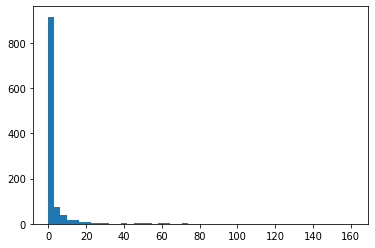

In [328]:
plt.hist(num_rhymes_poem, bins=50)
plt.show()

In [329]:
print(max(num_rhymes_poem))

161


### Adding features to data

In [330]:
train_data = raw_train_data
val_data = raw_val_data
test_data = raw_test_data

In [331]:
train_data

,poetry_text,wind\nand,quaint,sympathi,meet,life\nand,high,among,steep,splendour,...,advers,casual,i\n\ni,divers,midway,optic,charl,incess,outrag,poetry_author
0,—was this\nthat one fairest river lovd\nto ble...,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,William Wordsworth
1,sun arise\nand make happi skies\nth merri bell...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,William Blake
2,all truth sound bitter\na one first believes\n...,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Robert Browning
3,load brush basket cradl chairs\nlabour along s...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Thomas Hardy
4,sappho\nyea thou shalt forgotten like spilt wi...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Algernon Charles Swinburne
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1118,cri men “i would crucified”\n\nand said “whi b...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Kahlil Gibran
1119,silent silent night\nquench holi light\nof thi...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,William Blake
1120,youth told certain citi everi one lived\naccor...,0,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,Kahlil Gibran
1121,one love more mor sincer lie everywher place ...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Alice Notley


In [332]:
train_data['ave_word_len'] = ave_word_lens
train_data['ave_line_len'] = ave_line_lens
train_data['num_syllables'] = ave_syllable_lens
train_data['num_rhymes'] = num_rhymes_poem

In [333]:
train_data

,poetry_text,wind\nand,quaint,sympathi,meet,life\nand,high,among,steep,splendour,...,midway,optic,charl,incess,outrag,poetry_author,ave_word_len,ave_line_len,num_syllables,num_rhymes
0,—was this\nthat one fairest river lovd\nto ble...,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,William Wordsworth,4.903260,4.528571,7.447619,0
1,sun arise\nand make happi skies\nth merri bell...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,William Blake,4.085106,2.937500,3.812500,13
2,all truth sound bitter\na one first believes\n...,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,Robert Browning,4.494118,3.541667,5.125000,0
3,load brush basket cradl chairs\nlabour along s...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,Thomas Hardy,4.757576,4.714286,7.142857,4
4,sappho\nyea thou shalt forgotten like spilt wi...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,Algernon Charles Swinburne,4.718310,4.733333,7.000000,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1118,cri men “i would crucified”\n\nand said “whi b...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,Kahlil Gibran,5.344538,5.173913,8.869565,0
1119,silent silent night\nquench holi light\nof thi...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,William Blake,4.611111,2.400000,3.266667,8
1120,youth told certain citi everi one lived\naccor...,0,0,0,0,0,1,1,0,0,...,0,0,0,0,0,Kahlil Gibran,4.534783,4.600000,7.040000,0
1121,one love more mor sincer lie everywher place ...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,Alice Notley,4.420690,5.800000,9.280000,0


In [334]:
val_data['ave_word_len'] = list(map(ave_word_len, raw_val_data['poetry_text'].values))
val_data['ave_line_len'] = list(map(ave_line_len, raw_val_data['poetry_text'].values))
val_data['num_syllables'] = list(map(ave_syllables_line, raw_val_data['poetry_text'].values))
val_data['num_rhymes'] = list(map(num_rhymes, raw_val_data['poetry_text'].values))

In [335]:
test_data['ave_word_len'] = list(map(ave_word_len, raw_test_data['poetry_text'].values))
test_data['ave_line_len'] = list(map(ave_line_len, raw_test_data['poetry_text'].values))
test_data['num_syllables'] = list(map(ave_syllables_line, raw_test_data['poetry_text'].values))
test_data['num_rhymes'] = list(map(num_rhymes, raw_test_data['poetry_text'].values))

/Users/aysjajohnson/.pyenv/versions/3.7.4/lib/python3.7/site-packages/nltk/tokenize/sonority_sequencing.py:104: UserWarning: Character not defined in sonority_hierarchy, assigning as vowel: 'æ'
  " assigning as vowel: '{}'".format(c)


In [336]:
train_data.to_csv(processed_root("04-bow-added-features/feat_train_data-30.csv"))
val_data.to_csv(processed_root("04-bow-added-features/feat_val_data-30.csv"))
test_data.to_csv(processed_root("04-bow-added-features/feat_test_data-30.csv"))

In [337]:
print(ave_word_lens)

[4.903259726603575, 4.085106382978723, 4.4941176470588236, 4.757575757575758, 4.71830985915493, 4.385964912280702, 4.518518518518518, 4.204819277108434, 4.861940298507463, 4.8963809523809525, 4.579234972677596, 4.746478873239437, 4.607476635514018, 4.822085889570552, 5.0, 4.428571428571429, 4.36734693877551, 4.563380281690141, 4.945054945054945, 4.5394736842105265, 4.545454545454546, 4.235294117647059, 4.763888888888889, 5.0, 4.379746835443038, 5.253968253968254, 4.724137931034483, 4.493827160493828, 4.462686567164179, 4.734622144112478, 4.428571428571429, 5.169491525423729, 4.015151515151516, 4.36, 4.921052631578948, 4.315789473684211, 4.890510948905109, 4.928571428571429, 4.6, 4.702127659574468, 4.907407407407407, 4.588235294117647, 4.529220779220779, 4.6923076923076925, 4.877094972067039, 4.944598337950138, 4.761904761904762, 4.685185185185185, 5.072916666666667, 4.8108108108108105, 4.861111111111111, 3.9166666666666665, 4.421875, 4.397590361445783, 4.703703703703703, 4.787810383747